Представляю Вашему вниманию модель, которая предсказывает стоимость акций компании "Сбербанк", используя исторические значения стоимости акций, а также новостной фон.

Первым делом импортируем все нужные библиотеки.

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import requests
import datetime
import matplotlib.pyplot as plt

Эта группа библиотек вместе обеспечивает загрузку, обработку, анализ и визуализацию финансовых и временных данных.

In [2]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

Здесь мы подключаем библиотеку для работы с естественным языком, а именно поключаем модуль VADER для анализа тональности текста.

In [3]:
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

Эти библиотеки мы будем использовать для масштабирования данных и построения рекуррентных нейронных сетей.

In [4]:
sber = yf.Ticker("SBER.ME")
price_data = sber.history(period="max").reset_index()
price_data.to_csv("sberbank_price.csv", index=False)

from api import api_key

news_api_key = api_key
url = f"https://newsapi.org/v2/everything?q=Сбербанк&language=ru&sortBy=publishedAt&apiKey={news_api_key}"
response = requests.get(url)
if response.status_code == 200:
    news_json = response.json()
    articles = news_json.get("articles", [])
    news_list = []
    for article in articles:
        published_at = article.get("publishedAt")
        title = article.get("title")
        if published_at and title:
            published_date = pd.to_datetime(published_at).date()
            news_list.append({"Date": published_date, "Headline": title})
    if news_list:
        news_data = pd.DataFrame(news_list)
        news_data = news_data.groupby("Date").agg({"Headline": " | ".join}).reset_index()
        news_data.to_csv("sberbank_news.csv", index=False)
    else:
        print("Новостные данные не найдены.")
else:
    print("Ошибка при получении новостей:", response.status_code)

 Эта часть программы собирает исторические данные о котировках акций "Сбербанка" и новостные заголовки по теме "Сбербанк", после чего сохраняет их в два отдельных CSV-файла для последующего анализа.

In [5]:
price_data = pd.read_csv('sberbank_price.csv', parse_dates=['Date'])
price_data.sort_values('Date', inplace=True)
price_data.reset_index(drop=True, inplace=True)

def compute_ichimoku(df, conversion_period=9, base_period=26, leading_span_period=52, displacement=26, fill_na=False):
    df['tenkan_sen'] = (df['High'].rolling(window=conversion_period).max() +
                        df['Low'].rolling(window=conversion_period).min()) / 2
    df['kijun_sen'] = (df['High'].rolling(window=base_period).max() +
                       df['Low'].rolling(window=base_period).min()) / 2
    df['senkou_span_a'] = ((df['tenkan_sen'] + df['kijun_sen']) / 2).shift(displacement)
    df['senkou_span_b'] = ((df['High'].rolling(window=leading_span_period).max() +
                            df['Low'].rolling(window=leading_span_period).min()) / 2).shift(displacement)
    df['chikou_span'] = df['Close'].shift(-displacement)
    if fill_na:
        df['senkou_span_a'] = df['senkou_span_a'].ffill()
        df['senkou_span_b'] = df['senkou_span_b'].ffill()
        df['chikou_span'] = df['chikou_span'].bfill()
    return df

price_data = compute_ichimoku(price_data)
price_data = price_data[['Date', 'Open', 'High', 'Low', 'Close', 'Volume',
                           'tenkan_sen', 'kijun_sen', 'senkou_span_a', 'senkou_span_b', 'chikou_span']]

Этот кусок кода подготавливает исторические данные и добавляет к ним технический индикатор Ишимоку, который затем будет использован для построения прогнозных моделей.

In [6]:
news_data = pd.read_csv('sberbank_news.csv', parse_dates=['Date'])
news_data.sort_values('Date', inplace=True)
news_data.reset_index(drop=True, inplace=True)

sia = SentimentIntensityAnalyzer()
def get_sentiment(text):
    return sia.polarity_scores(text)['compound']

news_data['sentiment'] = news_data['Headline'].apply(get_sentiment)
daily_sentiment = news_data.groupby('Date')['sentiment'].mean().reset_index()

Данная часть кода обрабатывает новостные данные, вычисляя для каждого заголовка индекс тональности, а затем усредняет его для каждой даты.

In [7]:
price_data['Date'] = pd.to_datetime(price_data['Date'], utc=True).dt.tz_localize(None)
daily_sentiment['Date'] = pd.to_datetime(daily_sentiment['Date'])
df = pd.merge(price_data, daily_sentiment, on='Date', how='left')
df['sentiment'] = df['sentiment'].fillna(0)

df = df.dropna()

features = ['Close', 'tenkan_sen', 'kijun_sen', 'senkou_span_a', 'senkou_span_b', 'sentiment']
target = 'Close'

scaler = MinMaxScaler()
df_scaled = df.copy()
df_scaled[features] = scaler.fit_transform(df[features])

def create_sequences(data, seq_length=30):
    xs = []
    ys = []
    for i in range(len(data) - seq_length):
        x = data.iloc[i:(i + seq_length)][features].values
        y = data.iloc[i + seq_length][target]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

sequence_length = 30
X, y = create_sequences(df_scaled, sequence_length)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

Эта часть предназначена для объединения и обработки финансовых данных и данных о новостной тональности, масштабирования выбранных признаков и формирования входных последовательностей для последующего обучения модели прогнозирования временных рядов.

In [8]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(50))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 40ms/step - loss: 0.0193 - val_loss: 0.0099
Epoch 2/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - loss: 0.0012 - val_loss: 0.0058
Epoch 3/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 0.0011 - val_loss: 0.0069
Epoch 4/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 9.2654e-04 - val_loss: 0.0044
Epoch 5/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 8.3490e-04 - val_loss: 0.0041
Epoch 6/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 8.4986e-04 - val_loss: 0.0051
Epoch 7/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - loss: 7.9863e-04 - val_loss: 0.0028
Epoch 8/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 9.4657e-04 - val_loss: 0.0046
Epoch 9/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 6.7873e-04 - val_loss: 0.0037
Epoch 10/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 7.6085e-04 - val_loss: 0.0066
Epoch 11/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 0.0011 - val_loss: 0.0036
Epoch 12/50
63/63 ━━━━━━━━━━━━━━━━━

Этот блок кода создаёт архитектуру модели (рекуррентную нейронную сеть), которая способна работать с последовательными данными (нашими временными рядами) и обучается прогнозировать значение целевой переменной (цену закрытия) на основе заданных входных признаков.

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step


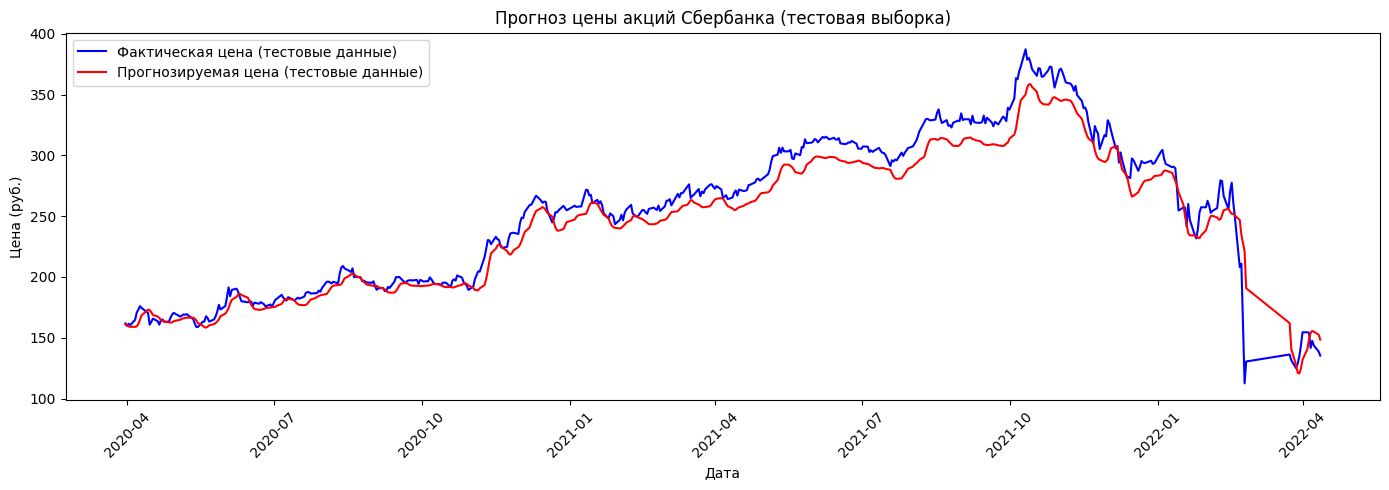

In [9]:
def inverse_transform_close(scaled_close):
    dummy = np.zeros((1, len(features)))
    dummy[0, 0] = scaled_close
    return scaler.inverse_transform(dummy)[0, 0]

real_y_test = np.array([inverse_transform_close(val) for val in y_test])
predicted_test = model.predict(X_test)
predicted_real = np.array([inverse_transform_close(val) for val in predicted_test.flatten()])

test_dates = df['Date'].iloc[sequence_length + train_size:].reset_index(drop=True)

plt.figure(figsize=(14, 5))
plt.plot(test_dates, real_y_test, color='blue', label='Фактическая цена (тестовые данные)')
plt.plot(test_dates, predicted_real, color='red', label='Прогнозируемая цена (тестовые данные)')
plt.title('Прогноз цены акций Сбербанка (тестовая выборка)')
plt.xlabel('Дата')
plt.ylabel('Цена (руб.)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Данный блок кода позволяет сравнить реальные (фактические) цены акций с прогнозируемыми моделью, используя реальные даты в качестве координат для визуализации.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


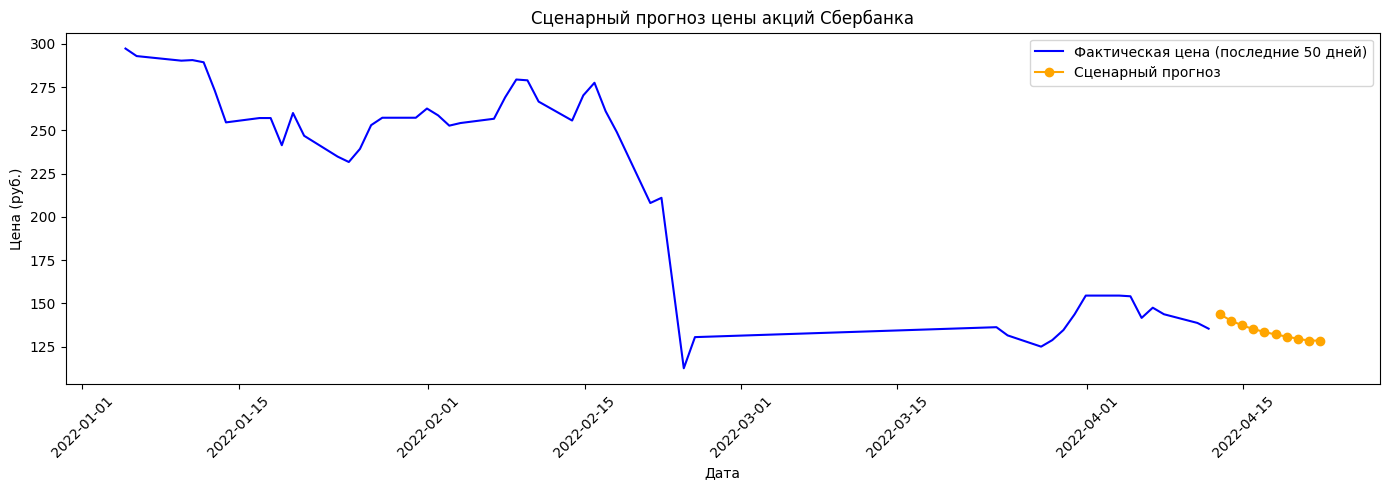

Сценарный прогноз на ближайшие дни:
2022-04-12: 143.71
2022-04-13: 140.08
2022-04-14: 137.27
2022-04-15: 135.19
2022-04-16: 133.45
2022-04-17: 132.02
2022-04-18: 130.79
2022-04-19: 129.57
2022-04-20: 128.46
2022-04-21: 128.53


In [10]:
future_days = 10
scenario_sentiment = df['sentiment'].tail(10).mean()

ext_df = df.copy()
future_predictions = []
future_dates = []

for i in range(future_days):
    last_date = ext_df['Date'].iloc[-1]
    new_date = last_date + pd.Timedelta(days=1)

    last_sequence = ext_df[features].tail(sequence_length)
    last_sequence_scaled = scaler.transform(last_sequence)
    last_sequence_scaled = np.expand_dims(last_sequence_scaled, axis=0)

    pred_scaled = model.predict(last_sequence_scaled)
    dummy = np.zeros((1, len(features)))
    dummy[0, 0] = pred_scaled[0, 0]
    pred_close = scaler.inverse_transform(dummy)[0, 0]

    last_close = ext_df['Close'].iloc[-1]
    new_open = last_close
    new_close = pred_close
    new_high = new_close * 1.01
    new_low = new_close * 0.99
    new_volume = ext_df['Volume'].iloc[-1]

    new_row = {
        'Date': new_date,
        'Open': new_open,
        'High': new_high,
        'Low': new_low,
        'Close': new_close,
        'Volume': new_volume,
        'tenkan_sen': np.nan,
        'kijun_sen': np.nan,
        'senkou_span_a': np.nan,
        'senkou_span_b': np.nan,
        'chikou_span': np.nan,
        'sentiment': scenario_sentiment
    }

    ext_df = pd.concat([ext_df, pd.DataFrame([new_row])], ignore_index=True)
    ext_df = compute_ichimoku(ext_df, fill_na=True)

    future_predictions.append(new_close)
    future_dates.append(new_date)

plt.figure(figsize=(14, 5))
plt.plot(df['Date'].tail(50), df['Close'].tail(50), label='Фактическая цена (последние 50 дней)', color='blue')
plt.plot(future_dates, future_predictions, label='Сценарный прогноз', color='orange', marker='o')
plt.title('Сценарный прогноз цены акций Сбербанка')
plt.xlabel('Дата')
plt.ylabel('Цена (руб.)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("Сценарный прогноз на ближайшие дни:")
for date, price in zip(future_dates, future_predictions):
    print(f"{date.date()}: {price:.2f}")


Этот блок кода строит сценарный прогноз, где будущие значения цены рассчитываются на основе модели и затем добавляются в DataFrame с последующим пересчётом технических индикаторов для корректной симуляции дальнейшей динамики.